In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate
from sklearn import linear_model

# cluster functions
empty = [0]
point = [1,2]
pair_1 = [3,4,5]; pair_2 = [6,7,8] 
pair_3 = [9,10,11,12]; pair_4 = [13,14,15]
triplet_1 = [16,17,18,19] 
triplet_2 = [20,21,22,23]
triplet_3 = [24,25,26,27,28,29]

def select_cluster(df_corr, clusters):
    if len(clusters) > 1:
        clus = []
        for i in clusters:
            clus = clus + i
    else:
        clus = clusters
    clus = np.array(clus)
    return df_corr.iloc[:,clus]

def weight(df_jdos):
    w = np.exp(df_jdos.gap.values.astype(float)/0.1)
    w = np.ones(len(df_jdos))
    return w

def calc_eci(corr,x, w):
    xx = np.concatenate(x.values)
    njdos = len(xx)/len(corr)
    xx = xx.reshape(len(corr), int(njdos))
    eci = linear_model.LinearRegression(fit_intercept=False)
    eci.fit(corr.values, xx, w)
    return eci

def pred(corr,eci):
    return np.dot(corr, eci.coef_.T)

def main(mat, clusters, verbose=False):
    global grid, df_jdos
    # read corr matrix and electronic densities
    df_corr = pd.read_csv('corr_{0}_jdos.csv'.format(mat), delim_whitespace=True)
    df_jdos = pd.read_hdf('jdos_{0}.h5'.format(mat))

    # semiconductors only
    # drop metallic structures
    semi = df_jdos[(df_jdos.gap >= 0.1)].index
    df_corr = df_corr.loc[semi]
    df_jdos = df_jdos.loc[semi]
    #df_jdos['jdos'] = df_jdos['jdos']/(grid+0.0001)**2
    if verbose:
        display(df_jdos);
    # keep original mesh and data
    grid = df_jdos.iloc[0]['energy']
    # define training set
    train = df_corr.sample(frac=0.8)
    df_corr_train = train.loc[:,"corr(0)":"corr(29)"]
    jdos_train = df_jdos.loc[train.index,'jdos']
    # test set
    test = df_corr.drop(train.index)
    df_corr_test = test.loc[:,"corr(0)":"corr(29)"]
    jdos_test = df_jdos.drop(train.index).loc[:,'jdos']

    # include the pair interactions up to the 5th NN, and the triplets up to the 2NN
    corr_train = select_cluster(df_corr_train, clusters)
    corr_test = select_cluster(df_corr_test, clusters)
    #
    w = weight(df_jdos.loc[train.index])
    #
    eci = calc_eci(corr_train, jdos_train, w)
    jdos_train_pred = pred(corr_train, eci)
    jdos_test_pred = pred(corr_test, eci)
    #   
    # test the cluster expansion on the test set
    # plot the real dos (gray) and the predicted dos (red)
    plt.rcParams['figure.figsize'] = [8, 12]
    for i in range(len(jdos_test)):
        plt.title("Cluster expanded JDOS: Test set")
        plt.plot(grid, jdos_test.iloc[i]+0.01*i, color='gray')
        plt.plot(grid, jdos_test_pred[i]+0.01*i, color='r')
    return eci

def ecjdos(mat,clusters,eci,ref_number):
    # plot DOS vs Temperature using the correlation matrix from MC simulations
    df_mc = pd.read_csv('mc_{0}.csv'.format(mat), delim_whitespace=True)
    df_mc = df_mc[df_mc['T'] <= 1000].reset_index()

    corr_str = []
    for i in range(30):
        corr_str.append("<corr({0:})>".format(i))
    df_corr_mc = df_mc.loc[:,corr_str]
    corr_mc = select_cluster(df_corr_mc, clusters)
    #
    jdos_mc_pred = pred(corr_mc, eci)
    # 
    plt.rcParams['figure.figsize'] = [10, 6]
    fig, ax = plt.subplots(1)
    norm = mpl.colors.Normalize(vmin=df_mc["T"].min(), vmax = df_mc["T"].max())
    cmap = mpl.cm.get_cmap('jet')
    c = [cmap(norm(temp)) for temp in df_mc["T"]]
    ax.set_xlim([0,1])
    ax.set_ylim([0,0.001])
    #ax.tick_params(labelleft=False) 
    for i in range(len(jdos_mc_pred)):
        ax.set_title("Temperature dependent JDOS")
        ax.plot(grid, jdos_mc_pred[i]+df_mc.loc[i,"T"]*0./400, color=c[i])
    cax, _ = mpl.colorbar.make_axes(ax)
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    # plot the kesterite reference dos
    ax.plot(grid, df_jdos.loc[ref_number, "jdos"], c='k', label='reference');
    ax.legend();

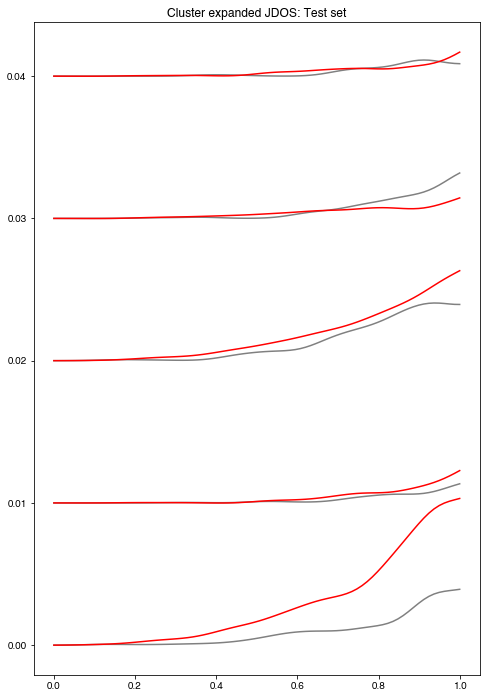

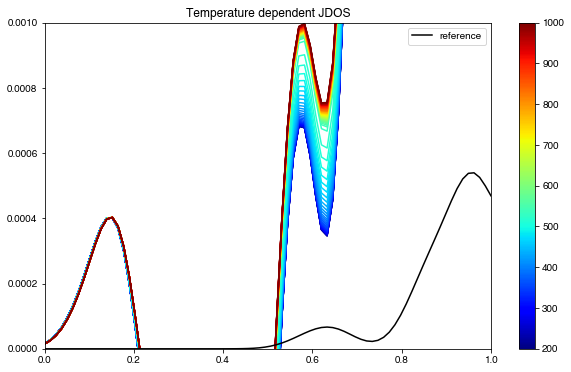

In [47]:
clusters = [empty, pair_1, pair_2]
eci_czts = main("czts", clusters, verbose=False)
ecjdos("czts", clusters, eci_czts, 3)

plt.show()

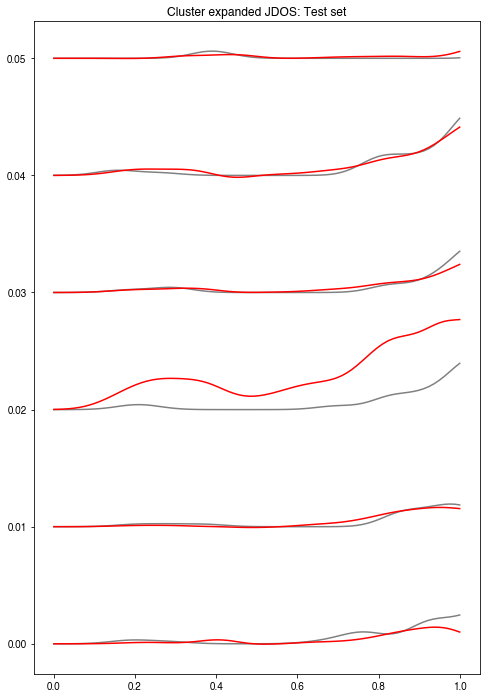

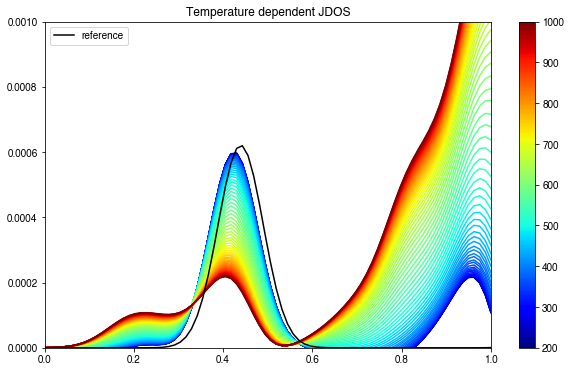

In [37]:
clusters = [empty, pair_1, pair_2]

eci_ccts = main("ccts", clusters, verbose=False)
ecjdos("ccts", clusters, eci_ccts, 91)

plt.show()